In [12]:
import numpy as np 
import pandas as pd 
import os 
import scipy 
import sklearn.model_selection
import math
from matplotlib import pyplot as plt

In [13]:
id_to_name = {}
id_to_col = {}
col_to_id = {}
file = pd.read_csv(r'ml-latest-small/movies.csv')
for i, (mov_id, name) in enumerate(zip(file['movieId'],file['title'])):
    mov_id = int(mov_id)
    id_to_col[mov_id] = i
    col_to_id[i] = mov_id
    id_to_name[mov_id] = name 

In [31]:
user_rows = []
user_cols = []

user_values = []
user_ids = []

user_ratings = {}



with open(r"ml-latest-small/ratings.csv",'r') as file:
    file.readline()
    for line in file:
        line_data = line.split(",")
        user_id = int(line_data[0])
        movie_id = int(line_data[1])
        rating = float(line_data[2])
        
        user_rows.append(user_id)
        user_cols.append(id_to_col[movie_id])
        user_values.append(rating)
        
        if not user_id in user_ids:
            user_ids.append(user_id)

In [32]:
my_ratings = []
my_id = 611
# I like:

# Captain America Winter Soldier
my_ratings.append((my_id,id_to_col[110102],5))
# Captain America Civil War
my_ratings.append((my_id,id_to_col[122920],5))
# Kung Fu Hustle 
my_ratings.append((my_id,id_to_col[31878],5))
# The Immitation Game
my_ratings.append((my_id,id_to_col[116797],5))
# Doctor Strange
my_ratings.append((my_id,id_to_col[122922],4))
# Pirates of the Carribean
my_ratings.append((my_id,id_to_col[6539],5))
# Moana 
my_ratings.append((my_id,id_to_col[166461],4))
# Guardians of the Galaxy 
my_ratings.append((my_id,id_to_col[112852],4))
# Mulan
my_ratings.append((my_id,id_to_col[1907],5))

# I dont like:

# Transformers
my_ratings.append((my_id,id_to_col[112370],0))
# Zathura 
my_ratings.append((my_id,id_to_col[40851],0))
# Pitch Perfect
my_ratings.append((my_id,id_to_col[96588],0))
# It
my_ratings.append((my_id,id_to_col[175303],0))
# Both of them
my_ratings.append((my_id,id_to_col[26693],0))
# Jumanji Jumanji
my_ratings.append((my_id,id_to_col[2],0))
# Dumb and Dumber to
my_ratings.append((my_id,id_to_col[116977],0))

for movie in my_ratings:
    my_id, movie_id, rating = movie
    user_rows.append(my_id)
    user_cols.append(movie_id)
    user_values.append(rating)
    
# Add myself to unique user ids 
user_ids.append(my_id)

In [33]:
matrix = scipy.sparse.coo_matrix((user_values,(user_rows, user_cols))).tocsr()

In [34]:
train_users = np.random.choice(user_ids,int(len(user_ids)*.80),replace=False)
test_users = [u for u in user_ids if not u in train_users]

# make sure Im in the training set!
if not my_id in train_users:
    np.append(train_users,my_id)
    test_users.remove(my_id)

In [35]:
def rmse(indices,values,p,q):
    T  = 1 / len(values)
    
    current_guess = p@q
    summed_err = 0 
    
    for i,v in zip(indices,values):
            row, col = i
            summed_err += (current_guess[row][col] - v) ** 2
    
    return  T * math.sqrt(summed_err)   

In [36]:
def find_best_fit(indices,values,rows,cols,dim):
    
    # Keep track of the best matrices weve found and make inits  
    best_min, best_max = None, None
    min_err = 100
    max_err = 0
    grid = []
    test_low, test_high = .05, 1.2 
    
    # test all combinations of low, and high values 
    for min_v in np.arange(test_low,test_high,.05):
        grid.insert(0,[])
        for max_v in np.arange(test_low,test_high,.05):
            if min_v >= max_v: # unless it doesnt make sense 
                grid[0].append(-1)
                continue
            p = min_v + (max_v - min_v) * np.random.rand(rows,dim)
            q = min_v + (max_v - min_v) * np.random.rand(dim,cols)
            error = rmse(indices,values,p,q)
            grid[0].append(error)
            if error > max_err:
                max_err = error
            if error < min_err:
                min_err = error 
                best_min = min_v
                best_max = max_v
                
    # set all non-calculated numbers as the 30% over the max (for nice coloring) 
    for i in range(len(grid)):
        for j in range(len(grid[i])):
            if grid[i][j] == -1:
                grid[i][j] = max_err * 1.3
                
    # Make a nice plot 
    plt.imshow(grid,extent = [test_low ,test_high, test_low,test_high],cmap='cool',vmin=0,vmax=max_err*1.4)
    plt.xlabel("min val")
    plt.ylabel("max val")
    plt.title("init rmse by min and max\nlight = min")
    #plt.show()

    return best_min, best_max   

In [37]:
def GradientDescent(indices,values,t_indices,t_values,rows,cols,p,q,dim=10,alpha=.1,iters=1,cutoff=.005):
    
    # Run 'iter' times
    train_rmses = []
    test_rmses = []
    
    for iteration in range(iters):
            
        for i, val in zip(indices,values):
            i, j = i # unpack indices 
            
            # Get jth col from q and ith row from p
            q_j = q[:,j]
            p_i = p[i]
                  
            a = p_i@q_j
                  
            # Find the err present
            err = val - a

            # Find how much to nudge down the gradient
            nudge = err * alpha

            # Update p and q vals down the gradient
            p[i] = p_i + q_j * nudge
            q[:,j] = q_j + p_i * nudge
                

        # Output
        if iteration % 3 == 0:
            train_error = rmse(indices,values,p,q)
            test_error = rmse(t_indices,t_values,p,q)
            try:
                delta_test = 100 * (test_rmses[-1] - test_error) / test_error
            except IndexError:
                delta_test = 1
            if len(test_rmses) > 1 and (delta_test < cutoff):
                return p,q,train_rmses,test_rmses
            train_rmses.append(train_error)
            test_rmses.append(test_error)     
    return p,q,train_rmses,test_rmses

In [38]:
# First well set parameters
dimension = int(input("choose a dimension to reduce to: "))
n_rows, n_cols = matrix.shape

# The train set 
train_indices = [(user_rows[i],user_cols[i]) for i in train_users]
train_values  = [user_values[i] for i in train_users] 

# The test set 
test_indices = [(user_rows[i],user_cols[i]) for i in test_users]
test_values  = [user_values[i] for i in test_users] 

choose a dimension to reduce to: 2


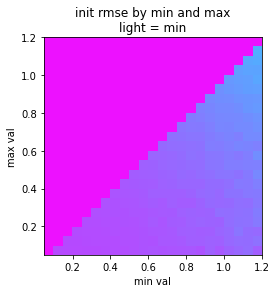

In [39]:
# Now, lets tweak min and max vals for the given dimension that will start off with the least rmse 
minimum_val , maximum_val = find_best_fit(train_indices,train_values,n_rows,n_cols,dimension)

In [40]:
# Make the p and q matrices now 
p = minimum_val + (maximum_val - minimum_val) * np.random.rand(n_rows,dimension)
q = minimum_val + (maximum_val - minimum_val) * np.random.rand(dimension,n_cols)

# And now lets do the actual calculation!
# Algorithm will cutoff at 'cutoff' as a percent change in rmse 
final_p,final_q,train_err,test_err = GradientDescent(train_indices,
                                                     train_values,

                                                     test_indices,
                                                     test_values,

                                                     n_rows,
                                                     n_cols,

                                                     p,
                                                     q,

                                                     dim=dimension,
                                                     alpha=.00001,
                                                     iters=100000,
                                                     cutoff=.01)

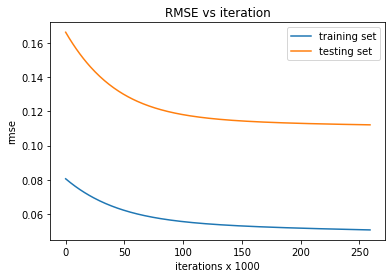

In [41]:
plt.plot(train_err,label='training set')
plt.plot(test_err,label='testing set')
plt.xlabel("iterations x 1000")
plt.ylabel("rmse")
plt.title("RMSE vs iteration")
plt.legend()

In [42]:
# And now lets see my rating suggestions!
suggestions = p@q

my_suggestions = []
for _ in range(10):
    
    top_suggestion = 0
    top_movie = None 
    for movie_id, rating in enumerate(suggestions[my_id]):
        if rating > top_suggestion and not movie_id in my_suggestions:
            top_suggestion = rating
            top_movie = movie_id
    my_suggestions.append(top_movie)
    print(f"You should watch: {id_to_name[col_to_id[top_movie]]} rated {top_suggestion:.2f}")

You should watch: Fantasia (1940) rated 2.59
You should watch: Road Warrior, The (Mad Max 2) (1981) rated 2.59
You should watch: Wizard of Oz, The (1939) rated 2.58
You should watch: Fugitive, The (1993) rated 2.58
You should watch: Gone with the Wind (1939) rated 2.57
You should watch: Jungle Book, The (1967) rated 2.57
You should watch: Eat Drink Man Woman (Yin shi nan nu) (1994) rated 2.57
You should watch: L.I.E. (2001) rated 2.57
You should watch: Inside Job (2010) rated 2.57
You should watch: Flirting With Disaster (1996) rated 2.56


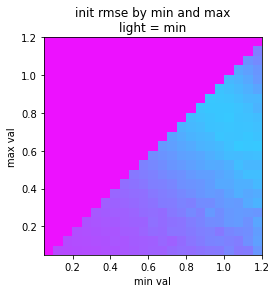

In [43]:
dimension = 5
minimum_val , maximum_val = find_best_fit(train_indices,train_values,n_rows,n_cols,dimension)
# Make the p and q matrices now 
p = minimum_val + (maximum_val - minimum_val) * np.random.rand(n_rows,dimension)
q = minimum_val + (maximum_val - minimum_val) * np.random.rand(dimension,n_cols)

# And now lets do the actual calculation!
# Algorithm will cutoff at 'cutoff' as a percent change in rmse 
final_p,final_q,train_err,test_err = GradientDescent(train_indices,
                                                     train_values,

                                                     test_indices,
                                                     test_values,

                                                     n_rows,
                                                     n_cols,

                                                     p,
                                                     q,

                                                     dim=dimension,
                                                     alpha=.00001,
                                                     iters=100000,
                                                     cutoff=.01)

Text(0, 0.5, 'RMSE')

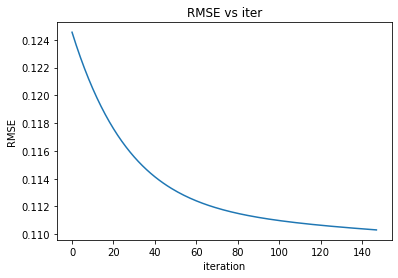

In [44]:
plt.plot(test_err)
plt.title("RMSE vs iter")
plt.xlabel("iteration")
plt.ylabel("RMSE")

In [45]:
# And now lets see my rating suggestions!
suggestions = p@q

my_suggestions = []
for _ in range(10):
    
    top_suggestion = 0
    top_movie = None 
    for movie_id, rating in enumerate(suggestions[my_id]):
        if rating > top_suggestion and not movie_id in my_suggestions:
            top_suggestion = rating
            top_movie = movie_id
    my_suggestions.append(top_movie)
    print(f"You should watch: {id_to_name[col_to_id[top_movie]]} rated {top_suggestion:.2f}")

You should watch: Damn Yankees! (1958) rated 4.81
You should watch: Citizen Kane (1941) rated 4.77
You should watch: Last Hurrah for Chivalry (Hao xia) (1979) rated 4.75
You should watch: Jason and the Argonauts (1963) rated 4.73
You should watch: Brake (2012) rated 4.73
You should watch: Something to Talk About (1995) rated 4.73
You should watch: Rory O'Shea Was Here (Inside I'm Dancing) (2004) rated 4.72
You should watch: Collector, The (La collectionneuse) (1967) rated 4.71
You should watch: Balls of Fury (2007) rated 4.71
You should watch: Ted 2 (2015) rated 4.71
